# MIMIC-III Data Processing

This notebook is used for processing data from the MIMIC-III clinical database. We will use various Python libraries to manipulate and visualize the data.

## Description of the MIMIC-III Dataset

The MIMIC-III (Medical Information Mart for Intensive Care III) dataset is a large, freely-available database comprising de-identified health-related data associated with over forty thousand patients who stayed in critical care units of the Beth Israel Deaconess Medical Center between 2001 and 2012. The database includes information such as demographics, vital signs, laboratory tests, medications, and more.

## Importing Libraries

First, we need to import the necessary libraries for data manipulation and visualization.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import timedelta

# Functions for Processing MIMIC-III Data

This section contains functions to process and visualize the MIMIC-III dataset. Specifically, we will plot procedure durations and concatenate overlapping procedures.

## Function: plot_procedures

This function plots the procedure durations for a given ICUSTAY_ID with overlaps and exact times on the x-axis.

In [2]:
def plot_procedures(icustay_id, df):
    """
    Plot the procedure durations for a given ICUSTAY_ID with overlaps and exact times on the x-axis.

    Parameters:
    icustay_id (int): The ICUSTAY_ID for which the plot will be generated.
    df (DataFrame): The dataframe containing the procedures data.
    """
    # Import required for handling date formatting
    import matplotlib.dates as mdates

    # Filter the dataframe for the provided ICUSTAY_ID
    icustay_procedures = df[df['ICUSTAY_ID'] == icustay_id]

    # Set up the figure with a smaller size
    fig, ax = plt.subplots(figsize=(10, 5))

    # Create a list of start and end times to easily compare overlaps
    procedure_times = [(pd.to_datetime(row['STARTTIME']), pd.to_datetime(row['ENDTIME'])) for index, row in icustay_procedures.iterrows()]
    
    # Flatten the list of tuples and get unique times for x-axis ticks
    unique_times = sorted(set([time for times in procedure_times for time in times]))

    # Draw lines for each procedure
    for index, (start_time, end_time) in enumerate(procedure_times):
        # Drawing a line for the procedure duration
        ax.plot([start_time, end_time], [index, index], color="skyblue", lw=2, marker='o', markersize=8)

    # Highlight overlaps
    for i, (start_i, end_i) in enumerate(procedure_times):
        for j, (start_j, end_j) in enumerate(procedure_times):
            if i != j and start_i < end_j and end_i > start_j:  # Check for overlap
                # Overlap detected, highlight by plotting a thicker red line
                overlap_start = max(start_i, start_j)  # Start of overlap is the latest start time
                overlap_end = min(end_i, end_j)  # End of overlap is the earliest end time
                ax.plot([overlap_start, overlap_end], [i, i], color="red", lw=4, zorder=5)
                ax.plot([overlap_start, overlap_end], [j, j], color="red", lw=4, zorder=5)

    # Formatting the dates on the x-axis to make them more readable
    ax.set_xticks(unique_times)  # Set custom ticks
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))  # Set the formatter for the ticks
    plt.gcf().autofmt_xdate()  # Rotate date labels

    # Set the y-axis labels to 'First Procedure', 'Second Procedure', etc.
    y_labels = [f'{ordinal} Procedimento' for ordinal in ['Primeiro', 'Segundo', 'Terceiro', 'Quarto', 'Fifth', 'Sixth', 'Seventh', 'Eighth', 'Ninth', 'Tenth']][:len(procedure_times)]
    plt.yticks(range(len(procedure_times)), y_labels)

    # Labels and title
    plt.xlabel('Data e hora')
    plt.title(f'Duração dos procedimentos do ICUSTAY_ID {icustay_id}')
    plt.grid(True)

    # Display the plot
    plt.show()

## Function: concatenate_overlapping_procedures

This function concatenates all overlapping procedures for each ICUSTAY_ID into a single procedure.

In [ ]:
def concatenate_overlapping_procedures(df):
    """
    Concatenate all overlapping procedures for each ICUSTAY_ID into a single procedure.

    Parameters:
    df (DataFrame): The dataframe containing the procedures data with overlapping info.
    
    Returns:
    DataFrame: A dataframe with the overlapping procedures concatenated.
    """
    concatenated_procedures = []

    for icustay_id, subject_id in zip(df['ICUSTAY_ID'].unique(), df['SUBJECT_ID']):
        # Sort the procedures by start time
        icustay_procedures = df[df['ICUSTAY_ID'] == icustay_id].sort_values(by='STARTTIME')

        # Initialize variables to keep track of the current merged procedure
        current_start = None
        current_end = None
        merged_procedure = None

        for index, row in icustay_procedures.iterrows():
            start_time = pd.to_datetime(row['STARTTIME'])
            end_time = pd.to_datetime(row['ENDTIME'])

            if merged_procedure is None:
                # Start a new merged procedure
                merged_procedure = (icustay_id, subject_id, start_time, end_time)
                current_start, current_end = start_time, end_time
            elif start_time <= current_end:
                # Extend the current merged procedure
                current_end = max(current_end, end_time)
                merged_procedure = (icustay_id, subject_id, current_start, current_end)
            else:
                # Save the current merged procedure and start a new one
                concatenated_procedures.append(merged_procedure)
                current_start, current_end = start_time, end_time
                merged_procedure = (icustay_id, subject_id, start_time, end_time)

        # Save the last merged procedure
        if merged_procedure:
            concatenated_procedures.append(merged_procedure)

    # Create a DataFrame from the concatenated procedures
    concatenated_df = pd.DataFrame(concatenated_procedures, columns=['ICUSTAY_ID', 'SUBJECT_ID', 'STARTTIME', 'ENDTIME'])
    concatenated_df['STARTTIME'] = pd.to_datetime(concatenated_df['STARTTIME'])
    concatenated_df['ENDTIME'] = pd.to_datetime(concatenated_df['ENDTIME'])
    concatenated_df['TIME_SPENT'] = (pd.to_datetime(concatenated_df['ENDTIME']) - pd.to_datetime(concatenated_df['STARTTIME'])).dt.total_seconds() / 3600
    concatenated_df['PREVIOUS_PROCEDURE_END'] = concatenated_df.groupby('ICUSTAY_ID')['ENDTIME'].shift()
    concatenated_df['PREVIOUS_PROCEDURE_END'] = pd.to_datetime(concatenated_df['PREVIOUS_PROCEDURE_END'].fillna(concatenated_df['STARTTIME']))
    concatenated_df['TIME_SINCE_LAST_INTUBATION'] = (concatenated_df['STARTTIME'] - concatenated_df['PREVIOUS_PROCEDURE_END']).dt.total_seconds() / 3600

    return concatenated_df

# Apply the function to concatenate overlapping procedures

## Loading and Filtering Procedure Events Data

In this section, we will load the procedure events data from a CSV file, filter it for invasive ventilation events, and calculate the time spent on each procedure.

### Explanation of the Code

- **INVASIVE_VENTILATION**: This variable holds the ITEMID for invasive ventilation procedures.
- **Loading Data**: The `pd.read_csv` function is used to load the procedure events data from a CSV file.
- **Filtering Data**: The dataframe is filtered to include only rows where the `ITEMID` matches the invasive ventilation ITEMID.
- **Calculating Time Spent**: The `TIME_SPENT` column is calculated by finding the difference between `ENDTIME` and `STARTTIME` and converting it to hours.
- **Selecting Columns**: Only the relevant columns are selected for further analysis.
- **Printing Summary**: The number of rows and unique ICUSTAY_IDs in the filtered dataframe are printed.
- **Displaying Data**: The first few rows of the dataframe are displayed using the `head` method.

In [4]:
# Define the ITEMID for invasive ventilation
INVASIVE_VENTILATION = 225792

# Load the procedure events data from a CSV file
chartevents_df = pd.read_csv('/Users/felipeakiomatsuoka/Desktop/PIBIC/csvs/PROCEDUREEVENTS_MV.csv')

# Filter the dataframe to include only rows where ITEMID is for invasive ventilation
chartevents_df = chartevents_df[chartevents_df['ITEMID'].isin([INVASIVE_VENTILATION])]

# Calculate the time spent on each procedure in hours
chartevents_df['TIME_SPENT'] = (pd.to_datetime(chartevents_df['ENDTIME']) - pd.to_datetime(chartevents_df['STARTTIME'])).dt.total_seconds() / 3600

# Select relevant columns for further analysis
chartevents_df = chartevents_df[['ICUSTAY_ID', 'SUBJECT_ID', 'STARTTIME', 'ENDTIME', 'ITEMID', 'TIME_SPENT', 'STATUSDESCRIPTION']]

# Print the number of rows and unique ICUSTAY_IDs in the filtered dataframe
print("There are " + str(len(chartevents_df)) + " rows and " + str(len(chartevents_df['ICUSTAY_ID'].unique())) + " ICUSTAYS_IDs")

# Display the first few rows of the dataframe
chartevents_df.head()

There are 10749 rows and 9119 ICUSTAYS_IDs


,ICUSTAY_ID,SUBJECT_ID,STARTTIME,ENDTIME,ITEMID,TIME_SPENT,STATUSDESCRIPTION
2,232563.0,29070,2145-03-12 23:05:00,2145-03-18 20:01:00,225792,140.933333,FinishedRunning
23,237055.0,31608,2133-01-10 01:00:00,2133-02-03 12:37:00,225792,587.616667,FinishedRunning
89,243526.0,30354,2154-12-24 12:06:00,2154-12-26 17:00:00,225792,52.900000,FinishedRunning
142,267692.0,18082,2156-02-24 11:38:00,2156-02-27 14:00:00,225792,74.366667,Stopped
188,258818.0,27143,2189-12-09 13:00:00,2189-12-14 13:34:00,225792,120.566667,FinishedRunning


## Sorting and Calculating Time Intervals

In this section, we will sort the procedure events data by ICUSTAY_ID and STARTTIME, calculate the end time of the previous procedure, and compute the time since the last intubation.

### Explanation of the Code

- **Sorting Data**: The dataframe is sorted by `ICUSTAY_ID` and `STARTTIME` to ensure procedures are in chronological order.
- **Previous Procedure End Time**: The `PREVIOUS_PROCEDURE_END` column is calculated by shifting the `ENDTIME` within each `ICUSTAY_ID` group.
- **Handling Missing Values**: Missing values in `PREVIOUS_PROCEDURE_END` are filled with the `STARTTIME` of the current procedure.
- **Datetime Conversion**: The `STARTTIME` column is converted to datetime format for accurate time calculations.
- **Time Since Last Intubation**: The `TIME_SINCE_LAST_INTUBATION` column is calculated as the difference between `STARTTIME` and `PREVIOUS_PROCEDURE_END`, converted to hours.
- **Displaying Data**: The first 50 rows of the dataframe are displayed using the `head` method.

In [ ]:
# Sort the dataframe by ICUSTAY_ID and STARTTIME
chartevents_df = chartevents_df.sort_values(by=['ICUSTAY_ID', 'STARTTIME'])

# Calculate the end time of the previous procedure for each ICUSTAY_ID
chartevents_df['PREVIOUS_PROCEDURE_END'] = chartevents_df.groupby('ICUSTAY_ID')['ENDTIME'].shift()

# Fill missing values in PREVIOUS_PROCEDURE_END with the STARTTIME of the current procedure
chartevents_df['PREVIOUS_PROCEDURE_END'] = pd.to_datetime(chartevents_df['PREVIOUS_PROCEDURE_END'].fillna(chartevents_df['STARTTIME']))

# Convert STARTTIME to datetime format
chartevents_df['STARTTIME'] = pd.to_datetime(chartevents_df['STARTTIME'])

# Calculate the time since the last intubation in hours
chartevents_df['TIME_SINCE_LAST_INTUBATION'] = (chartevents_df['STARTTIME'] - chartevents_df['PREVIOUS_PROCEDURE_END']).dt.total_seconds() / 3600

# Display the first 50 rows of the dataframe
chartevents_df.head(50)

: 

## Plotting and Concatenating Procedures

In this section, we will plot the procedure durations for a specific ICUSTAY_ID, concatenate overlapping procedures, and then plot the procedures again to visualize the changes.

### Explanation of the Code

- **Initial Plot**: The `plot_procedures` function is called to plot the procedure durations for `ICUSTAY_ID` 200063 before concatenation.
- **Concatenating Procedures**: The `concatenate_overlapping_procedures` function is called to merge overlapping procedures in the dataframe.
- **Printing Summary**: The number of rows that were concatenated is printed.
- **Final Plot**: The `plot_procedures` function is called again to plot the procedure durations for `ICUSTAY_ID` 200063 after concatenation.


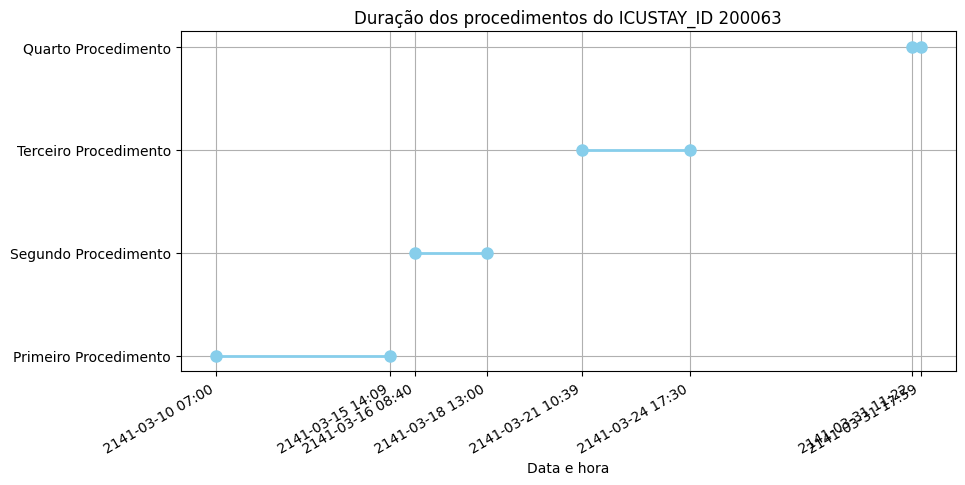

In [6]:
# Plot the procedure durations for ICUSTAY_ID 200063 before concatenation
plot_procedures(200063, chartevents_df)

# Concatenate overlapping procedures in the dataframe
chartevents_df_no_overlap = concatenate_overlapping_procedures(chartevents_df)

# Print the number of rows that were concatenated
print("There were " + str(len(chartevents_df) - len(chartevents_df_no_overlap)) + " rows that were concatenated")

# Plot the procedure durations for ICUSTAY_ID 200063 after concatenation
plot_procedures(200063, chartevents_df_no_overlap)

## Filtering and Labeling Procedures

In this section, we will filter the procedures to include only those with a duration greater than 24 hours, set up analysis time windows, and label the procedures based on the time since the last intubation.

### Explanation of the Code

- **Filtering Procedures**: The dataframe is filtered to include only procedures with a `TIME_SPENT` greater than 24 hours.
- **Setting Analysis Start Time**: The `START_ANALYSIS` column is set to the `ENDTIME` of each procedure.
- **Setting Analysis End Time**: The `END_ANALYSIS` column is set to 24 hours after the `START_ANALYSIS` time.
- **Labeling Procedures**: The `LABEL` column is set to 1 if the `TIME_SINCE_LAST_INTUBATION` is less than or equal to 48 hours and not zero, otherwise it is set to 0.
- **Displaying Data**: The first few rows of the dataframe are displayed using the `head` method.

In [ ]:
# Filter the dataframe to include only procedures with a duration greater than 24 hours
chartevents_df_no_overlap = chartevents_df_no_overlap.loc[chartevents_df_no_overlap['TIME_SPENT'] > 24.0]

# Set the START_ANALYSIS column to the end time of the procedure
chartevents_df_no_overlap['START_ANALYSIS'] = pd.to_datetime(chartevents_df_no_overlap['ENDTIME'])

# Set the END_ANALYSIS column to 24 hours after the START_ANALYSIS time
chartevents_df_no_overlap['END_ANALYSIS'] = chartevents_df_no_overlap['START_ANALYSIS'] + timedelta(hours=24)

# Label the procedures: 1 if the time since the last intubation is less than or equal to 48 hours and not zero, otherwise 0
chartevents_df_no_overlap['LABEL'] = ((chartevents_df_no_overlap['TIME_SINCE_LAST_INTUBATION'] <= 48) & (chartevents_df_no_overlap['TIME_SINCE_LAST_INTUBATION'] != 0)).astype(int)

# Display the first few rows of the dataframe
chartevents_df_no_overlap.head()

: 

## Visualizing Extubation Errors

In this section, we will create a bar plot to visualize the count of patients with and without extubation errors.

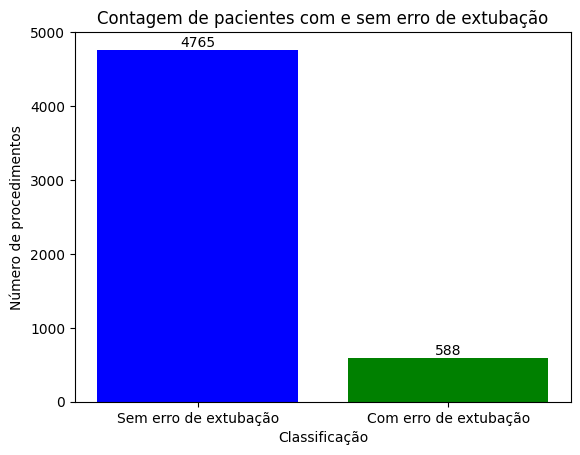

In [9]:
plt.bar(chartevents_df_no_overlap['LABEL'].value_counts().index, chartevents_df_no_overlap['LABEL'].value_counts().values, color=['blue', 'green'])
plt.xlabel('Classificação')
plt.ylabel('Número de procedimentos')
plt.xticks([0, 1], ['Sem erro de extubação', 'Com erro de extubação'])
plt.title('Contagem de pacientes com e sem erro de extubação')

for i, v in enumerate(chartevents_df_no_overlap['LABEL'].value_counts().values):
    plt.text(i, v, str(v), ha='center', va='bottom')

plt.show()

## Mapping Patient Death Information

In this section, we will load patient data, create mappings for death status and hospital death time, and then map these to the procedure events data.

### Explanation of the Code

- **Loading Patient Data**: The patient data is loaded from a CSV file using `pd.read_csv`.
- **Creating 'DEAD' Column**: A new column 'DEAD' is created based on the 'EXPIRE_FLAG' column.
- **Dropping Columns**: Unnecessary columns ('EXPIRE_FLAG', 'DOB', 'DOD_SSN', 'DOD') are dropped from the dataframe.
- **Displaying Data**: The first few rows of the patients dataframe are displayed using the `head` method.
- **Creating Dictionaries**: Dictionaries `dead_dict` and `dod_hosp_dict` are created to map `SUBJECT_ID` to `DEAD` and `DOD_HOSP`, respectively.
- **Mapping Data**: The `SUBJECT_ID` from `chartevents_df_no_overlap` is mapped to `DEAD` and `DOD_HOSP` using the created dictionaries.
- **Displaying Updated Data**: The first 5 rows of the updated `chartevents_df_no_overlap` dataframe are displayed using the `head` method.

In [10]:
patients_df = pd.read_csv('PATIENTS.csv')
patients_df['DEAD'] = patients_df['EXPIRE_FLAG']
patients_df = patients_df.drop(['EXPIRE_FLAG', 'DOB', 'DOD_SSN', 'DOD'], axis=1)
patients_df.head()

,ROW_ID,SUBJECT_ID,GENDER,DOD_HOSP,DEAD
0,234,249,F,NaN,0
1,235,250,F,2188-11-22 00:00:00,1
2,236,251,M,NaN,0
3,237,252,M,NaN,0
4,238,253,F,NaN,0


In [11]:
patients_df = pd.read_csv('PATIENTS.csv')
patients_df['DEAD'] = patients_df['EXPIRE_FLAG']
patients_df = patients_df.drop(['EXPIRE_FLAG', 'DOB', 'DOD_SSN', 'DOD'], axis=1)
patients_df.head()

dead_dict = patients_df.set_index('SUBJECT_ID')['DEAD'].to_dict()
dod_hosp_dict = patients_df.set_index('SUBJECT_ID')['DOD_HOSP'].to_dict()

# Map the `SUBJECT_ID` from `chartevents_df_no_overlap` to `DEAD` and `DOD_HOSP`
chartevents_df_no_overlap['DEAD'] = chartevents_df_no_overlap['SUBJECT_ID'].map(dead_dict)
chartevents_df_no_overlap['DEATH_TIME'] = chartevents_df_no_overlap['SUBJECT_ID'].map(dod_hosp_dict)

# Display the head of the updated DataFrame
chartevents_df_no_overlap.head(5)

,ICUSTAY_ID,SUBJECT_ID,STARTTIME,ENDTIME,TIME_SPENT,PREVIOUS_PROCEDURE_END,TIME_SINCE_LAST_INTUBATION,START_ANALYSIS,END_ANALYSIS,LABEL,DEAD,DEATH_TIME
3,200033.0,56369,2198-08-10 17:30:00,2198-08-20 12:20:00,234.833333,2198-08-10 17:30:00,0.000000,2198-08-20 12:20:00,2198-08-21 12:20:00,0,1,2198-08-21 00:00:00
4,200034.0,98276,2186-01-20 15:05:00,2186-01-23 15:38:00,72.550000,2186-01-20 15:05:00,0.000000,2186-01-23 15:38:00,2186-01-24 15:38:00,0,0,NaN
6,200063.0,99052,2141-03-10 07:00:00,2141-03-15 14:09:00,127.150000,2141-03-10 07:00:00,0.000000,2141-03-15 14:09:00,2141-03-16 14:09:00,0,0,NaN
7,200063.0,99052,2141-03-16 08:40:00,2141-03-18 13:00:00,52.333333,2141-03-15 14:09:00,18.516667,2141-03-18 13:00:00,2141-03-19 13:00:00,1,0,NaN
8,200063.0,99052,2141-03-21 10:39:00,2141-03-24 17:30:00,78.850000,2141-03-18 13:00:00,69.650000,2141-03-24 17:30:00,2141-03-25 17:30:00,0,0,NaN


## Saving the Processed Data

After all that, it's finally time to save our  processed data to a CSV file!

In [12]:
chartevents_df_no_overlap.to_csv('chartevents_processed.csv')